In [2]:
import seaborn as sns

iris = sns.load_dataset('iris')
X = iris.drop('species', axis=1)
y = iris['species']

# print(y)

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# print(y)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=1,
    stratify=y
)

In [5]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

lr = LogisticRegression()
rf_clf = RandomForestClassifier()
svc = SVC()
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf_clf), ('svc', svc)],
    voting='hard'
)

In [6]:
from sklearn.metrics import classification_report

for clf in (lr, rf_clf, svc, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy        

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

bg_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=0.6,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1
)
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}')
print(f'oob_score: {bg_clf.oob_score_}')

accuracy_score: 0.9777777777777777
oob_score: 0.9428571428571428


# AdaBoost

In [8]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=500,
    algorithm='SAMME',
    random_state=1
)

ada_clf.fit(X_train, y_train)
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print("AdaBoost train/test accuracies %0.3f / %0.4f"%(ada_train, ada_test))

AdaBoost train/test accuracies 1.000 / 0.9778


# Gradient Boost

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

gb_clf = GradientBoostingClassifier(
    learning_rate=0.099,
    n_estimators=500,
    max_depth=2
)
gb_clf.fit(X_train, y_train)

accuracies = [accuracy_score(y_test, y_pred) for y_pred in gb_clf.staged_predict(X_test)] # 매 stage마다 정밀도 산출
best_n_estimator = np.argmax(accuracies)

print(f"Best n_estimator: {best_n_estimator}")

gb_best = GradientBoostingClassifier(
    learning_rate=0.099,
    n_estimators=best_n_estimator,
    max_depth=2
)
gb_best.fit(X_train, y_train)
y_train_pred = gb_best.predict(X_train)
y_test_pred = gb_best.predict(X_test)

print(f'Train accuracy_score: {accuracy_score(y_train, y_train_pred)}')
print(f'Test accuracy_score: {accuracy_score(y_test, y_test_pred)}')

Best n_estimator: 1
Train accuracy_score: 0.9523809523809523
Test accuracy_score: 0.9555555555555556


# 교차검증 추가

In [10]:
from sklearn.model_selection import cross_val_score

# 교차 검증을 통해 최적의 n_estimators 찾기
n_estimators_range = range(1, 501)
cross_val_accuracies = []

for n in n_estimators_range:
    gb_clf = GradientBoostingClassifier(
        learning_rate=0.099,
        n_estimators=n,
        max_depth=2
    )
    scores = cross_val_score(gb_clf, X_train, y_train, cv=5, scoring='accuracy')
    cross_val_accuracies.append(scores.mean())

best_n_estimator = np.argmax(cross_val_accuracies) + 1

print(f"Best n_estimator: {best_n_estimator}")

gb_best = GradientBoostingClassifier(
    learning_rate=0.099,
    n_estimators=best_n_estimator,
    max_depth=2
)
gb_best.fit(X_train, y_train)
y_train_pred = gb_best.predict(X_train)
y_test_pred = gb_best.predict(X_test)

print(f'Train accuracy_score: {accuracy_score(y_train, y_train_pred)}')
print(f'Test accuracy_score: {accuracy_score(y_test, y_test_pred)}')

Best n_estimator: 6
Train accuracy_score: 0.9714285714285714
Test accuracy_score: 0.9777777777777777


# CatBoost

In [14]:
from catboost import CatBoostClassifier, Pool

train_dataset = Pool(data=X_train, label=y_train)
eval_dataset = Pool(data=X_test, label=y_test)

model = CatBoostClassifier(
    l2_leaf_reg=0.01,
    iterations=10,
    depth = 2,
    loss_function='MultiClass'
)
model.fit(train_dataset, use_best_model=True, eval_set=eval_dataset)

0:	learn: 1.0472421	test: 1.0452713	best: 1.0452713 (0)	total: 101us	remaining: 913us
1:	learn: 1.0183495	test: 1.0216092	best: 1.0216092 (1)	total: 253us	remaining: 1.01ms
2:	learn: 0.9742127	test: 0.9796928	best: 0.9796928 (2)	total: 439us	remaining: 1.02ms
3:	learn: 0.9319050	test: 0.9371843	best: 0.9371843 (3)	total: 548us	remaining: 823us
4:	learn: 0.8939962	test: 0.8985023	best: 0.8985023 (4)	total: 684us	remaining: 684us
5:	learn: 0.8588119	test: 0.8625838	best: 0.8625838 (5)	total: 906us	remaining: 604us
6:	learn: 0.8289021	test: 0.8328717	best: 0.8328717 (6)	total: 1.02ms	remaining: 435us
7:	learn: 0.8084883	test: 0.8185666	best: 0.8185666 (7)	total: 1.1ms	remaining: 275us
8:	learn: 0.7833542	test: 0.7927203	best: 0.7927203 (8)	total: 1.18ms	remaining: 131us
9:	learn: 0.7587002	test: 0.7666363	best: 0.7666363 (9)	total: 1.24ms	remaining: 0us

bestTest = 0.7666363273
bestIteration = 9



In [15]:
model.get_best_score()

{'learn': {'MultiClass': 0.7587002153046112},
 'validation': {'MultiClass': 0.7666363272673726}}

In [16]:
model.get_best_iteration()

9

In [20]:
feature_names = model.feature_names_
print(feature_names)

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


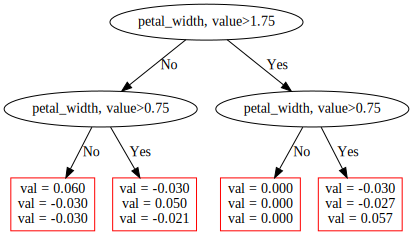

In [21]:
model.plot_tree(tree_idx=0, pool=train_dataset)